In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import r2_score, f1_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/imputed_city_hour_scaled.txt')

# Filter for City == Delhi
data = data[data['City'] == 'Delhi']

label_encoder = LabelEncoder()
data['AQI_Bucket_Encoded'] = label_encoder.fit_transform(data['AQI_Bucket'])

# Split inputs and output
X = data[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']].values
y = data['AQI'].values
y_aqi_bucket = data['AQI_Bucket_Encoded'].values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [ ]:
n_components = 6
svd = TruncatedSVD(n_components=n_components)
X_reduced = svd.fit_transform(X_normalized)

print("Original Shape:", X_normalized.shape)
print("Reduced Shape:", X_reduced.shape)


Original Shape: (38709, 12)
Reduced Shape: (38709, 6)


In [ ]:
print("Explained Variance Ratio:", svd.explained_variance_ratio_)
print("Cumulative Explained Variance:", svd.explained_variance_ratio_.cumsum())

Explained Variance Ratio: [0.33782983 0.14323542 0.11234526 0.08591918 0.06972615 0.06151025]
Cumulative Explained Variance: [0.33782983 0.48106525 0.5934105  0.67932968 0.74905583 0.81056608]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Move tensors to the same device as the model
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Define ANN
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(6, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.output(x)
        return x

# Initialize model, loss, and optimizer
model = ANN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Initialize lists to store loss values
loss_values = []

# Train model
epochs = 3000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Save loss for plotting
    loss_values.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 100/3000, Loss: 47020.37109375
Epoch 200/3000, Loss: 36232.96484375
Epoch 300/3000, Loss: 28237.529296875
Epoch 400/3000, Loss: 22405.818359375
Epoch 500/3000, Loss: 17795.244140625
Epoch 600/3000, Loss: 14256.875
Epoch 700/3000, Loss: 11597.236328125
Epoch 800/3000, Loss: 9594.54296875
Epoch 900/3000, Loss: 8072.0126953125
Epoch 1000/3000, Loss: 6918.7236328125
Epoch 1100/3000, Loss: 6023.75732421875
Epoch 1200/3000, Loss: 5324.6259765625
Epoch 1300/3000, Loss: 4782.91650390625
Epoch 1400/3000, Loss: 4364.9482421875
Epoch 1500/3000, Loss: 4050.592529296875
Epoch 1600/3000, Loss: 3795.98388671875
Epoch 1700/3000, Loss: 3586.05419921875
Epoch 1800/3000, Loss: 3420.84033203125
Epoch 1900/3000, Loss: 3285.36474609375
Epoch 2000/3000, Loss: 3175.08203125
Epoch 2100/3000, Loss: 3078.185302734375
Epoch 2200/3000, Loss: 2996.671630859375
Epoch 2300/3000, Loss: 2927.88525390625
Epoch 2400/3000, Loss: 2866.3583984375
Epoch 2500/3000, Loss: 2815.10546875
Epoch 2600/3000, Loss: 2775.2976074

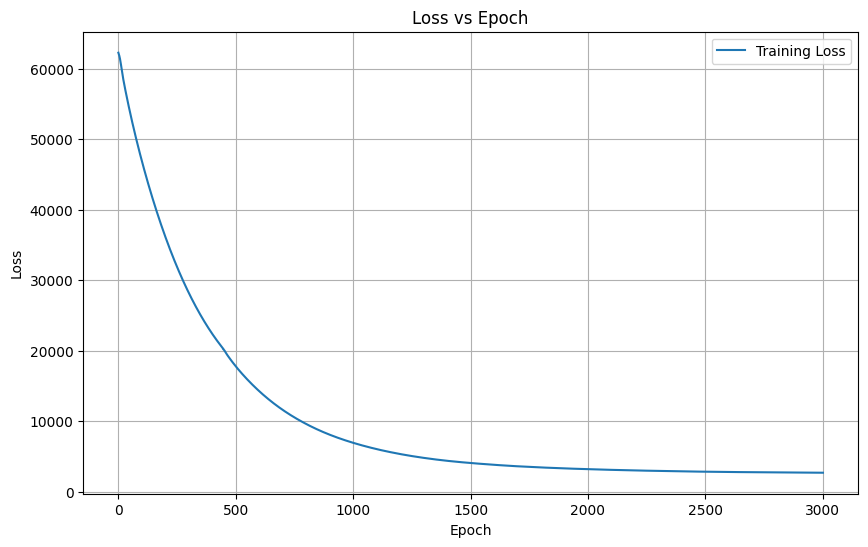

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    # Calculate metrics
    mae = mean_absolute_error(y_test_np, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_np, predictions))
    r2 = r2_score(y_test_np, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")


Mean Absolute Error (MAE): 40.2091
Root Mean Squared Error (RMSE): 54.4674
R-squared (R²): 0.7300
